# README:

 - To conduct the experiment copy one of the Batch # section, and modify the Parameters section. Beforehand run the Imports and Consts, Functions and Load Data sections

# Models to check:


# TODO: Write out some parameters for models
1. [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)
    1. Parameters:
        - asd
2. LDA
3. QDA
4. KNN
5. SVM
4. [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
5. [Voting?](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

# Feature Selectors to check:

1. KBest
    1. Parameters: 
         - k: 5,10,20,40,80
         - socre_func: f_classif, mutual_info_classif
2. FPR
    1. Parameters:
        - score_func: f_classif, mutual_info_classif
        - alpha: 0.001, 0.01, 0.05, 0.1
3. FDR
    1. Parameters:
        - score_func: f_classif, mutual_info_classif
        - alpha: 0.001, 0.01, 0.05, 0.1
4. Fwe
    1. Parameters:
        - score_func: f_classif, mutual_info_classif
        - alpha: 0.001, 0.01, 0.05, 0.1
5. KBest with one of the above as score func? Just some best values
5. Some tree based
    1. Parameters:
        - The same as chosen classifier, can be the same as GradientBoostingClassifier for example
7. RFE
    1. Parameters:
        - estimator: KNeighborsClassifier (n_neighbors=sqrt(number of features to select)), SVR(kernel="linear", "rbf"),DecisionTreeClassifier()
        - n_features_to_select: 5, 10, 20
        - step: 0.5, 0.2
8. RFECV
    1. Parameters:
        - estimator: KNeighborsClassifier (n_neighbors=sqrt(number of features to select)), , SVR(kernel="linear", "rbf"),DecisionTreeClassifier()
        - step: 0.5, 0.2
        - min_features_to_select: 5,10,20
        - cv: 5, 10, 15
9. SequentialFeatureSelector:
    1. Parameters:
        - estimator: KNeighborsClassifier (n_neighbors=sqrt(number of features to select)), , SVR(kernel="linear", "rbf"),DecisionTreeClassifier()
        - n_features_to_select: 5, 10, 20



# Batches based on the above:
1. 
    1. Models: LDA, QDA, KNN, SVR, GradientBoosting, HistGradientBoosting. Basic params
    2. Selectors: KBest
1. 
    1. Models: LDA, QDA, KNN, SVR, GradientBoosting, HistGradientBoosting. Basic params
    2. Selectors: KBest (with some best params), FPR, FDR, FWE
1. 
    1. Models: LDA, QDA, KNN, SVR, GradientBoosting, HistGradientBoosting. Basic params
    2. Selectors: Best from the above, RFE, RFECV, SequentialFeatureSelector (this batch will take ages)

Next choose 3-5 best methods with some current best params and create batches for classifiers

#  TODO: Create Batches for classifiers after writing out their params

# TODO: Finally focus on one selector and one classifier and find best possible values for them



# TODO:

1. Choose different params and run batches
2. Maybe extract the functions to separate .py to make the notebook cleaner
4. Additionaly at the end we could run [GridSearch](https://scikit-learn.org/stable/modules/grid_search.html) maybe but it's probably not needed
5. Write the report
6. Prepare the presentation

# Imports and Consts

In [51]:
import pickle
import numpy as np
import pandas as pd
import itertools
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (
    f_classif,
    mutual_info_classif,
    SelectKBest,
    RFE,
    RFECV,
    SelectFpr,
    SelectFdr,
    SelectFwe,
)
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

In [52]:
RESULTS_COLUMNS = [
    "score",
    "model",
    "model_parameters",
    "feature_selector",
    "selector_parameters",
]

# Functions

## Generate parameters


In [53]:
def namestr(obj, namespace) -> str:
    """Get name of a variable as a string"""
    return [name for name in namespace if namespace[name] is obj]

In [54]:
def generateParameters(arrays, namespace):
    """Takes any number of arrays and returns an array of
    dictionaries with keys as array names and values, all possible combinations

    namespace in general should be globals() or locals()
    """

    allCombinations = list(itertools.product(*arrays))

    allCombinations = [list(elem) for elem in allCombinations]

    arrayNames = []

    for array in arrays:
        arrayNames.append(namestr(array, namespace)[0])

    return [dict(zip(arrayNames, value)) for value in allCombinations]

- example usage, create arrays with parameters (their names should be the same as desired parameter names), pass them in an array to generateParamters function

In [55]:
arr1 = [1, 2, 7]
arr2 = [3, 4, 8]
generateParameters([arr1, arr2], globals())

[{'arr1': 1, 'arr2': 3},
 {'arr1': 1, 'arr2': 4},
 {'arr1': 1, 'arr2': 8},
 {'arr1': 2, 'arr2': 3},
 {'arr1': 2, 'arr2': 4},
 {'arr1': 2, 'arr2': 8},
 {'arr1': 7, 'arr2': 3},
 {'arr1': 7, 'arr2': 4},
 {'arr1': 7, 'arr2': 8}]

## Model helpers

- definition of available models and feature selection methods

- getters for models and feature selection methods

In [56]:
class ModelType(Enum):
    """Available classifiers"""

    LDA = 0

    QDA = 1

    DecisionTree = 2

    KNN = 3

    SVR = 4

    GradientBoosting = 5

    HistGradientBoosting = 6
    

In [57]:
def getModel(modelType, arguments):
    """Returns a classifier that can fit() and predict()"""

    match modelType:

        case ModelType.LDA:

            return LinearDiscriminantAnalysis(**arguments)

        case ModelType.QDA:

            return QuadraticDiscriminantAnalysis(**arguments)

        case ModelType.DecisionTree:

            return DecisionTreeClassifier(**arguments)

        case ModelType.KNN:

            return KNeighborsClassifier(**arguments)
        
        case ModelType.SVR:

            return SVR(**arguments)
        
        case ModelType.GradientBoosting:

            return GradientBoostingClassifier(**arguments)
        
        case ModelType.HistGradientBoosting:

            return HistGradientBoostingClassifier(**arguments)

In [58]:
class FeatureSelectorType(Enum):
    """Available Feature Selectors that can fit_transform() a dataset"""

    NoFeatureSelection = 0

    KBest = 1

    RFE = 2

    RFECV = 3

    FPR = 4

    FDR = 5

    FWE = 6

In [59]:
class NoFeatureSelection:
    """Wrapper class for no feature selection, exposes
    fit_transform method that returns unchanged X
    """

    def fit_transform(self, X, y):

        return X

In [60]:
def getFeatureSelector(selectorType, arguments):
    """Returns a feature selector that can fit_transform()"""

    match selectorType:

        case FeatureSelectorType.NoFeatureSelection:

            return NoFeatureSelection()

        case FeatureSelectorType.KBest:

            return SelectKBest(**arguments)

        case FeatureSelectorType.RFE:

            return RFE(**arguments)

        case FeatureSelectorType.RFECV:

            return RFECV(**arguments)

        case FeatureSelectorType.FPR:

            return SelectFpr(**arguments)

        case FeatureSelectorType.FDR:

            return SelectFdr(**arguments)

        case FeatureSelectorType.FWE:

            return SelectFwe(**arguments)

## Experiment process

In [61]:
def getScore(y_true, y_pred, featuresUsed):
    """Get score based on y_true, y_pred and number of feature used

    Scoring function, based on which, the best model is selected.
    Score is calculated according to task description: +10 points for each
    correctly classified positive class, -200 points for each feature used
    """

    score = 0

    correct = 0

    for i, y in enumerate(y_true):
        if y == y_pred[i]:
            correct += 1

    score = 10 * correct - 200 * featuresUsed
    return score

In [62]:
def performExperiment(X_train, y_train, X_test, y_test, model):
    """Returns a score for given model and provided data"""

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    finalResult = getScore(y_test, y_pred, len(X_train[0]))
    # finalResult = getScore(y_test, y_pred, model["classification"].n_features_in_)

    #

    # Take only 1000 of the highest class 1 probabilities

    # TODO: Turn it into a dataframe and keep track of the indexes

    # finalResult = np.sort(result[:, 1])[::-1][:1000]

    return finalResult

In [63]:
def conductExperiments(models, featureSelectors, X_orig, y_orig):
    """Collects score results for all provided models and feature selectors on given dataset

    Parameters:

    models: array in a format: [{"model":"model name","parameters":[{paramters object}]}]

    featureSelectors: array in a format: [{"model":"model name","parameters":[{paramters object}]}]


    """
    results = []

    scaler = StandardScaler()

    for featureSelector in featureSelectors:
        for featureSelectorParameters in featureSelector["parameters"]:
            selector = getFeatureSelector(
                featureSelector["model"], featureSelectorParameters
            )
            X_new = scaler.fit_transform(X_orig, y_orig)

            X_new = selector.fit_transform(X_new, y_orig)

            if len(X_new[0]) > 1:
                X_split_train, X_split_test, y_split_train, y_split_test = (
                    train_test_split(X_new, y_orig, test_size=0.33, random_state=42)
                )
                for model in models:
                    for modelParameters in model["parameters"]:

                        # clf = Pipeline(
                        #     [
                        #         ("scaling", StandardScaler()),
                        #         (
                        #             "feature_selection",
                        #             getFeatureSelector(
                        #                 featureSelector["model"], featureSelectorParameters
                        #             ),
                        #         ),
                        #         (
                        #             "classification",
                        #             getModel(model["model"], modelParameters),
                        #         ),
                        #     ]
                        # )
                        X_new = selector.fit_transform(X_orig, y_orig)

                        result = performExperiment(
                            X_train=X_split_train,
                            y_train=y_split_train,
                            X_test=X_split_test,
                            y_test=y_split_test,
                            model=getModel(model["model"], modelParameters),
                        )

                        results.append(
                            [
                                result,
                                model["model"].name,
                                modelParameters,
                                featureSelector["model"].name,
                                featureSelectorParameters,
                            ]
                        )
            else:
                print(
                    featureSelector["model"],
                    "produced 1 or fewer features with parameters:",
                    featureSelectorParameters,
                )
    return results

## Results processing

In [64]:
def flattenArray(array):
    """Convert list of lists to a flat list"""
    return [element for list in array for element in list]

In [65]:
def processParameter(parameter):
    """Returns proper name of a paramter

    Some paramters (i.e. functions) need to be processed
    by extracting their name as str
    """
    if hasattr(parameter, "__name__"):
        return parameter.__name__
    else:
        return parameter

In [66]:
def getParameterName(column, parameter):
    """Helper function returns a new name for parameter to avoid collisions"""
    return column + "_" + parameter

In [67]:
def extractParamterInformation(df, parameterColumnName, parameterName):
    """
    Extract information about certain parameter and include it with
    the dataframe as a separate column in a format parameterColumnName+"_"+parameterName
    to avoid conflicts between model parameters and feature selector parameters
    MODIFIES THE PROVIDED DF
    """

    df[getParameterName(parameterColumnName, parameterName)] = df.apply(
        lambda x: (
            processParameter(x[parameterColumnName][parameterName])
            if parameterName in x[parameterColumnName].keys()
            else pd.NA
        ),
        axis=1,
    )

In [68]:
def extractParameterResults(resultsDf, models, featureSelectors):
    """Extract parameters from results for further results processing

    Prepares resulting parameters for further processing and appends
    resultsDf with columns corresponding to said parameters
    returns new dataframe and parameters
    """

    parameterName = []
    for featureSelector in featureSelectors:
        parameterName.append(list(featureSelector["parameters"][0].keys()))
    parameterName = list(set(flattenArray(parameterName)))

    parameterColumnName = ["selector_parameters"]

    parameters = generateParameters([parameterName, parameterColumnName], locals())

    parameterName = []
    for model in models:
        parameterName.append(list(model["parameters"][0].keys()))
    parameterName = list(set(flattenArray(parameterName)))
    parameterColumnName = ["model_parameters"]

    parameters = parameters + generateParameters(
        [parameterName, parameterColumnName], locals()
    )
    newDf = resultsDf.copy()
    for parameter in parameters:
        extractParamterInformation(newDf, **parameter)
    return newDf, parameters

In [69]:
def drawParameterResultsBoxplot(resultsDf, parameters):
    """Draw boxplots of how different parameters affect the score"""
    for parameter in parameters:
        grouped = resultsDf.groupby("feature_selector")
        for name, group in grouped:
            groupOnlyNa = group[group.isnull().any(axis=1)]
            group = group.dropna()

            if group.shape[0] > 0:
                plt.title(
                    "Score by " + str(parameter["parameterName"]) + " for " + name
                )
                sns.boxplot(
                    data=group.reset_index(),
                    x="model",
                    y="score",
                    hue=getParameterName(
                        parameter["parameterColumnName"], parameter["parameterName"]
                    ),
                )
                plt.show()
            if groupOnlyNa.shape[0] > 0:
                plt.title("Score for " + name)
                sns.boxplot(
                    data=groupOnlyNa.reset_index(),
                    x="model",
                    y="score",
                )
                plt.show()

In [ ]:
def drawParameterResultsBarplot(resultsDf, parameters):
    """Draw barplits of how different parameters affect the score"""
    for parameter in parameters:

        if parameter["parameterColumnName"] == RESULTS_COLUMNS[4]:
            plt.title("Score for parameter " + parameter["parameterName"])
            sns.barplot(
                data=resultsDf,
                x="model",
                y="score",
                hue=resultsDf[
                    [
                        "feature_selector",
                        getParameterName(
                            parameter["parameterColumnName"], parameter["parameterName"]
                        ),
                    ]
                ].apply(tuple, axis=1),
            )
            plt.tight_layout()
            plt.show()
        else:
            plt.title("Score for parameter " + parameter["parameterName"])
            sns.barplot(
                data=resultsDf,
                x="feature_selector",
                y="score",
                hue=resultsDf[
                    [
                        "model",
                        getParameterName(
                            parameter["parameterColumnName"], parameter["parameterName"]
                        ),
                    ]
                ].apply(tuple, axis=1),
            )
            plt.tight_layout()
            plt.show()

In [71]:
def filterDataframeByBestResultsForFeatureSelectors(resultsDf):
    """Extracts best results for each parameter for final comparison of feature selectors
    Returns a dataframe containing only the best results
    """
    filteredDf = resultsDf.copy()

    filteredDf = filteredDf.loc[
        filteredDf.groupby("feature_selector")["score"].idxmax()
    ]
    return filteredDf

In [72]:
def filterDataframeByBestResultsForModels(resultsDf):
    """Extracts best results for each parameter for final comparison of models
    Returns a dataframe containing only the best results
    """
    filteredDf = resultsDf.copy()

    filteredDf = filteredDf.loc[filteredDf.groupby("model")["score"].idxmax()]
    return filteredDf

In [73]:
def filterDataframeByBestResults(resultsDf):
    """Extracts best results for each parameter for final comparison
    Returns a dataframe containing only the best results
    """
    filteredDf = resultsDf.copy()
    return filteredDf[filteredDf["score"] == filteredDf["score"].max()]

# Load Data

load the training and test data in a format specified by task description

In [74]:
with open("./Dataset/x_test.txt") as file:
    X_test = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/x_train.txt") as file:
    X_train = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/y_train.txt") as file:
    y_train = [[float(digit) for digit in line.split()] for line in file]

In the X_test there are 500 features and 5000 observations, y_train contains 5000 values, X_train contains 500 features and 5000 observations

In [75]:
print("X_test datapoints:", len(X_test), " features:", len(X_test[0]))
print("X_train datapoints:", len(X_train), " features:", len(X_train[0]))
print("y_train datapoints:", len(y_train))

X_test datapoints: 5000  features: 500
X_train datapoints: 5000  features: 500
y_train datapoints: 5000


# Batch 1

## Consts

In [76]:
RESULTS_FILENAME = "./Results/results-1"

## Experiment

### Parameters

In [77]:
# LDA
solver = ["svd"]
ldaParameters = generateParameters([solver], globals())

# QDA
qdaParameters = [{}]

# KNN
n_neighbors = [5]
knnParameters = generateParameters([n_neighbors], globals())

# SVR
svrParameters = [{}]

# HistGradientBoosting
histGradientBoostingParameters = [{}]


# GradientBoosting
gradientBoostingParameters = [{}]


# Voting?




models = [
    {"model": ModelType.LDA, "parameters": ldaParameters},
    {"model": ModelType.QDA, "parameters": qdaParameters},
    {"model": ModelType.KNN, "parameters": knnParameters},
    {"model": ModelType.SVR, "parameters": svrParameters},
    {"model": ModelType.GradientBoosting, "parameters": gradientBoostingParameters},
    {"model": ModelType.HistGradientBoosting, "parameters": histGradientBoostingParameters},
]

In [78]:
# KBest
k = [5, 10, 20, 40, 80]
score_func = [f_classif, mutual_info_classif]
kBestParameters = generateParameters([score_func, k], globals())


featureSelectors = [
    {"model": FeatureSelectorType.NoFeatureSelection, "parameters": [{}]},
    {"model": FeatureSelectorType.KBest, "parameters": kBestParameters},
]

### Conducting the experiment

In [79]:
y_train = np.ravel(y_train, order="C")

In [80]:
%%time
results = conductExperiments(
    models=models, featureSelectors=featureSelectors, X_orig=X_train, y_orig=y_train
)
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump(results, f)

c:\Users\prusak.patryk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


CPU times: total: 5min 29s
Wall time: 15min 24s


## Results

In [81]:
with open(RESULTS_FILENAME, "rb") as input_file:
    results = pickle.load(input_file)

In [82]:
resultsDf = pd.DataFrame(
    results,
    columns=RESULTS_COLUMNS,
)

### Detailed Results

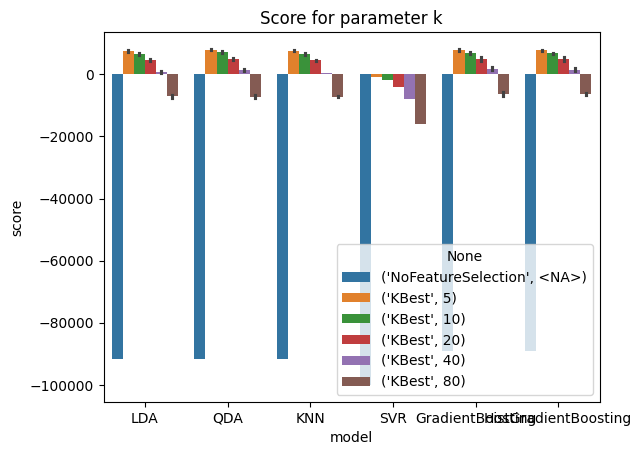

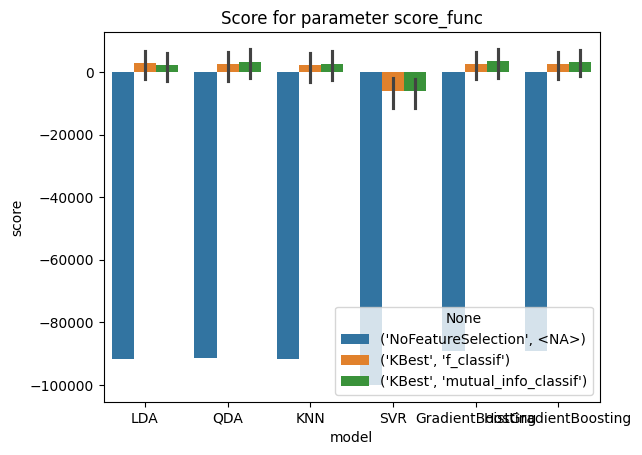

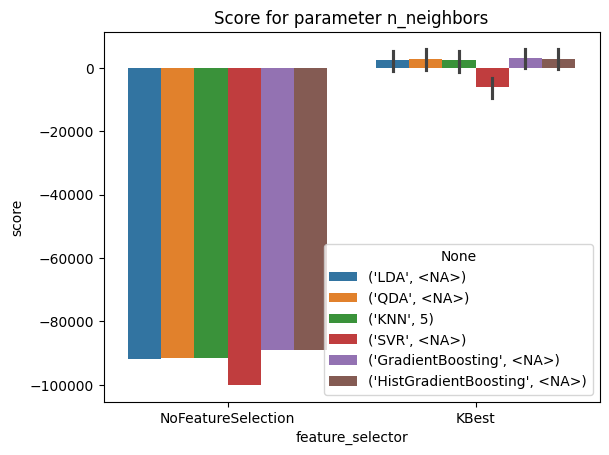

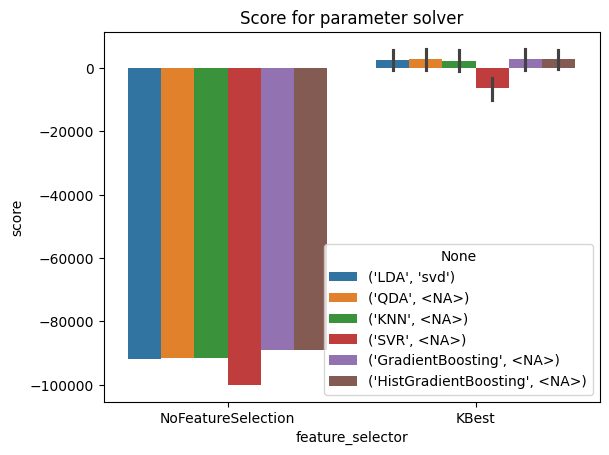

CPU times: total: 1.3 s
Wall time: 4.57 s


In [ ]:
%%time
processedResultsDf, parameters = extractParameterResults(
    resultsDf, models, featureSelectors
)
drawParameterResultsBarplot(processedResultsDf, parameters)

### Final Results for Feature Selectors

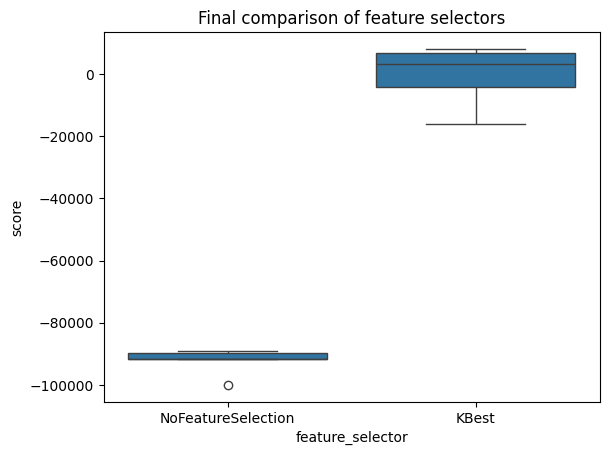

In [ ]:
plt.title("Final comparison of feature selectors")
sns.boxplot(data=processedResultsDf, x="feature_selector", y="score")
plt.tight_layout()
plt.show()

### Final Results for Models

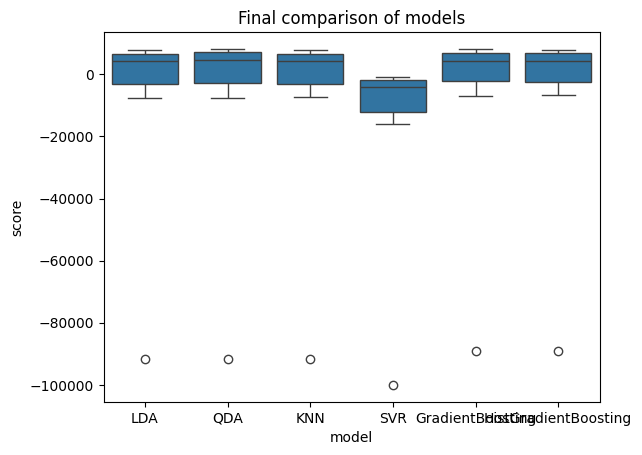

In [ ]:
plt.title("Final comparison of models")
sns.boxplot(data=processedResultsDf, x="model", y="score")
plt.tight_layout()
plt.show()

### Final Results

In [86]:
%%time
filteredDf = filterDataframeByBestResults(processedResultsDf)

CPU times: total: 0 ns
Wall time: 0 ns


In [87]:
filteredDf

,score,model,model_parameters,feature_selector,selector_parameters,selector_parameters_k,selector_parameters_score_func,model_parameters_n_neighbors,model_parameters_solver
37,8150,QDA,{},KBest,{'score_func': <function mutual_info_classif a...,5,mutual_info_classif,<NA>,<NA>


# Batch 2

## Consts

In [88]:
RESULTS_FILENAME = "./Results/results-2"

## Experiment

### Parameters

In [89]:
# LDA
solver = ["svd"]
ldaParameters = generateParameters([solver], globals())

# QDA
qdaParameters = [{}]

# KNN
n_neighbors = [5]
knnParameters = generateParameters([n_neighbors], globals())

# SVR
svrParameters = [{}]

# HistGradientBoosting
histGradientBoostingParameters = [{}]


# GradientBoosting
gradientBoostingParameters = [{}]


# Voting?




models = [
    {"model": ModelType.LDA, "parameters": ldaParameters},
    {"model": ModelType.QDA, "parameters": qdaParameters},
    {"model": ModelType.KNN, "parameters": knnParameters},
    {"model": ModelType.SVR, "parameters": svrParameters},
    {"model": ModelType.GradientBoosting, "parameters": gradientBoostingParameters},
    {"model": ModelType.HistGradientBoosting, "parameters": histGradientBoostingParameters},
]

In [90]:
# KBest
k = [2, 5, 10]
score_func = [mutual_info_classif]
kBestParameters = generateParameters([score_func, k], globals())

# FPR

# mutual_info_classif seems to break for FPR but maybe try to run these without StandardScaler?
score_func = [f_classif]
alpha = [0.01, 0.05, 0.1, 0.2]
fprParameters = generateParameters([score_func, alpha], globals())

# FDR
score_func = [f_classif]
alpha = [0.01, 0.05, 0.1, 0.2]
fdrParameters = generateParameters([score_func, alpha], globals())

# FWE
score_func = [f_classif]
alpha = [0.01, 0.05, 0.1, 0.2]
fweParameters = generateParameters([score_func, alpha], globals())


featureSelectors = [
    {"model": FeatureSelectorType.NoFeatureSelection, "parameters": [{}]},
    {"model": FeatureSelectorType.KBest, "parameters": kBestParameters},
    {"model": FeatureSelectorType.FPR, "parameters": fprParameters},
    {"model": FeatureSelectorType.FDR, "parameters": fdrParameters},
    {"model": FeatureSelectorType.FWE, "parameters": fweParameters},
]

### Conducting the experiment

In [91]:
y_train = np.ravel(y_train, order="C")

In [92]:
%%time
results = conductExperiments(
    models=models, featureSelectors=featureSelectors, X_orig=X_train, y_orig=y_train
)
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump(results, f)

c:\Users\prusak.patryk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Results

In [ ]:
with open(RESULTS_FILENAME, "rb") as input_file:
    results = pickle.load(input_file)

In [ ]:
resultsDf = pd.DataFrame(
    results,
    columns=RESULTS_COLUMNS,
)

### Detailed Results

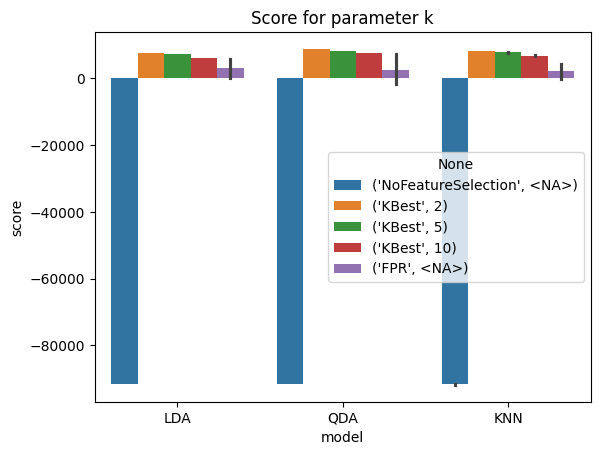

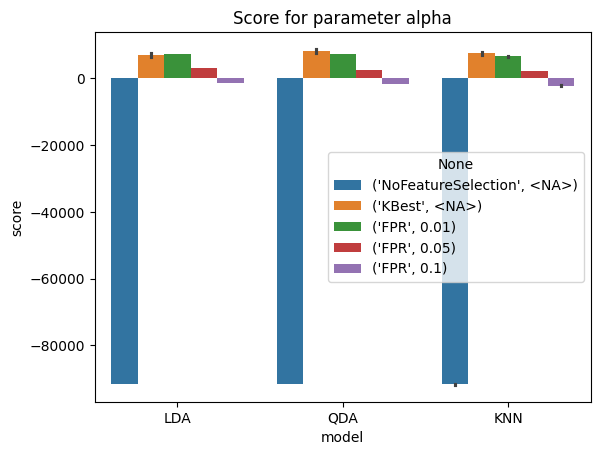

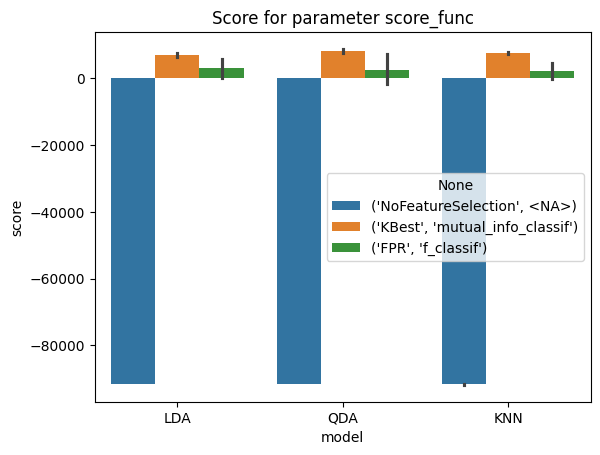

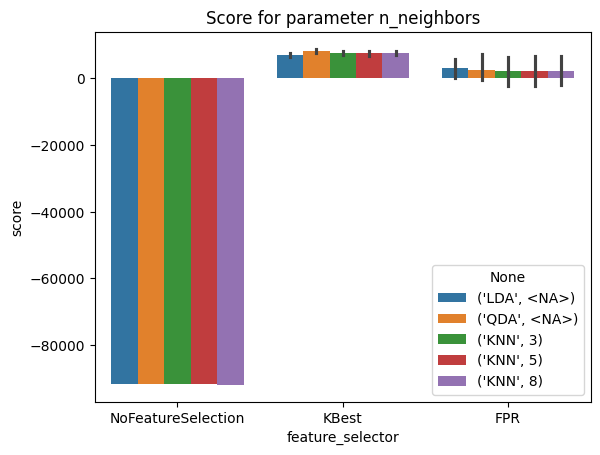

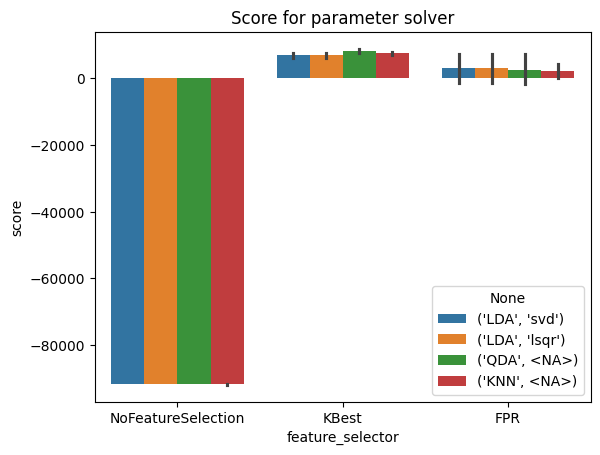

CPU times: total: 938 ms
Wall time: 4.76 s


In [ ]:
%%time
processedResultsDf, parameters = extractParameterResults(
    resultsDf, models, featureSelectors
)
drawParameterResultsBarplot(processedResultsDf, parameters)

### Final Results for Feature Selectors

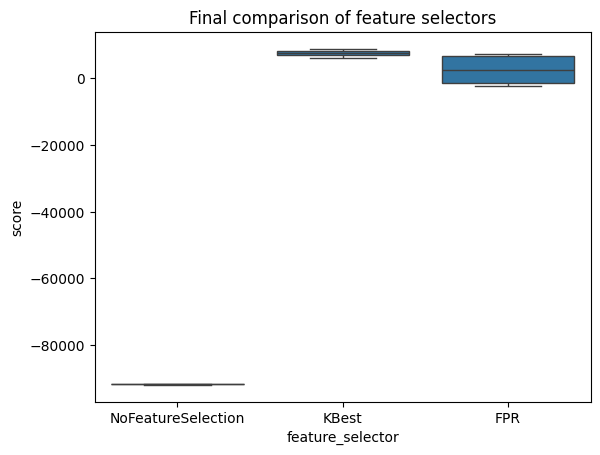

In [ ]:
plt.title("Final comparison of feature selectors")
sns.boxplot(data=processedResultsDf, x="feature_selector", y="score")
plt.show()

### Final Results for Models

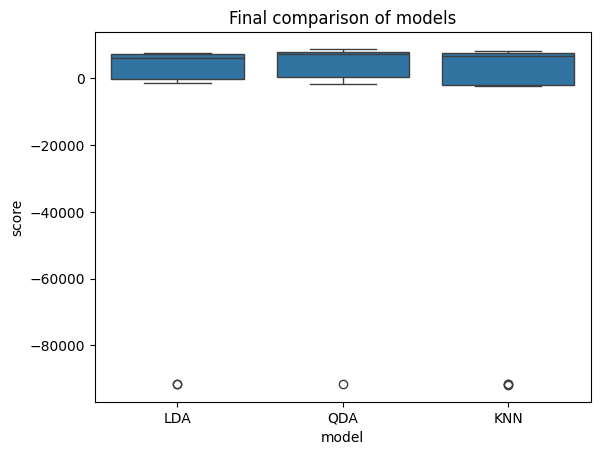

In [ ]:
plt.title("Final comparison of models")
sns.boxplot(data=processedResultsDf, x="model", y="score")
plt.show()

### Final Results

In [ ]:
%%time
filteredDf = filterDataframeByBestResults(processedResultsDf)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
filteredDf

,score,model,model_parameters,feature_selector,selector_parameters,selector_parameters_k,selector_parameters_alpha,selector_parameters_score_func,model_parameters_n_neighbors,model_parameters_solver
8,8860,QDA,{},KBest,{'score_func': <function mutual_info_classif a...,2,<NA>,mutual_info_classif,<NA>,<NA>


# Batch 21

## Consts

In [95]:
RESULTS_FILENAME = "./Results/results-21"

## Experiment

### Parameters

In [96]:
# TODO: Create parameter arrays

# LDA
solver = ["svd", "lsqr"]
ldaParameters = generateParameters([solver], globals())

# QDA


# TODO: Some ensembles, decision trees

models = [
    {"model": ModelType.LDA, "parameters": ldaParameters},
    {"model": ModelType.QDA, "parameters": [{}]},
]

In [97]:
# TODO: Create parameter arrays

# KBest
k = [5]
score_func = [mutual_info_classif]
kBestParameters = generateParameters([score_func, k], globals())

# RFE
estimator = [SVR(kernel="linear")]
n_features_to_select = [5, 10, 20]
step = [0.2, 0.5]
rfeParameters = generateParameters([estimator, n_features_to_select, step], globals())

# TODO: RFECV
estimator = [SVR(kernel="linear")]
min_features_to_select = [5, 10, 20]
step = [0.2, 0.5]
cv = [5, 10, 20]

rfeCvParameters = generateParameters(
    [estimator, min_features_to_select, step, cv], globals()
)

# TODO: SelectFPR

# TODO: SelectFwe

# TODO: SelectFdr

featureSelectors = [
    {"model": FeatureSelectorType.NoFeatureSelection, "parameters": [{}]},
    {"model": FeatureSelectorType.KBest, "parameters": kBestParameters},
    {"model": FeatureSelectorType.RFE, "parameters": rfeParameters},
    {"model": FeatureSelectorType.RFECV, "parameters": rfeCvParameters},
]

### Conducting the experiment

In [98]:
y_train = np.ravel(y_train, order="C")

In [99]:
%%time
results = conductExperiments(
    models=models, featureSelectors=featureSelectors, X_orig=X_train, y_orig=y_train
)
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump(results, f)

## Results

In [ ]:
with open(RESULTS_FILENAME, "rb") as input_file:
    results = pickle.load(input_file)

FileNotFoundError: [Errno 2] No such file or directory: './Results/results-3'

In [ ]:
resultsDf = pd.DataFrame(
    results,
    columns=RESULTS_COLUMNS,
)

### Detailed Results

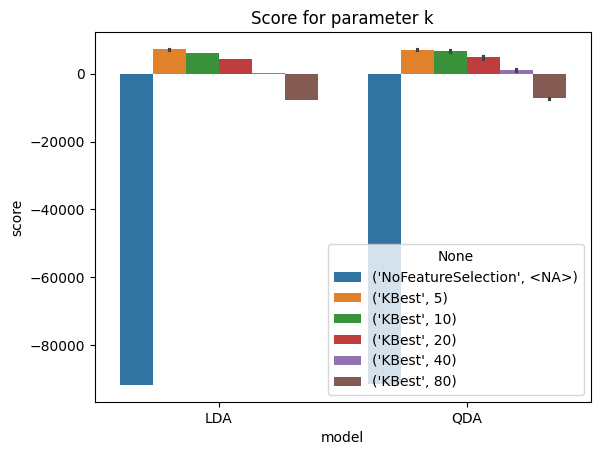

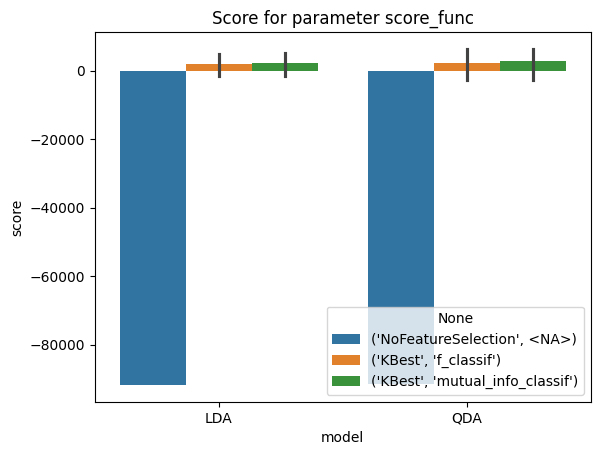

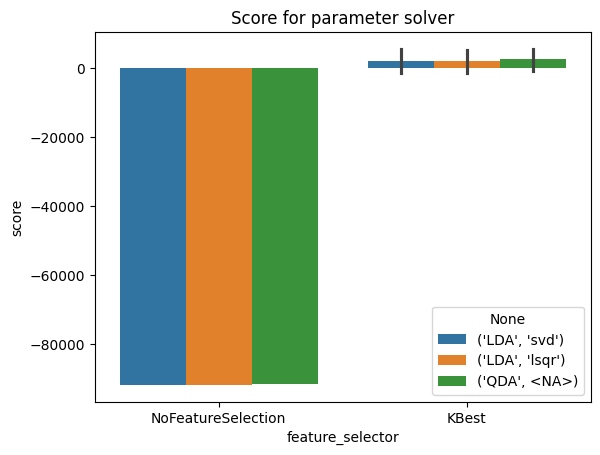

CPU times: total: 984 ms
Wall time: 2.05 s


In [ ]:
%%time
processedResultsDf, parameters = extractParameterResults(
    resultsDf, models, featureSelectors
)
drawParameterResultsBarplot(processedResultsDf, parameters)

### Final Results for Feature Selectors

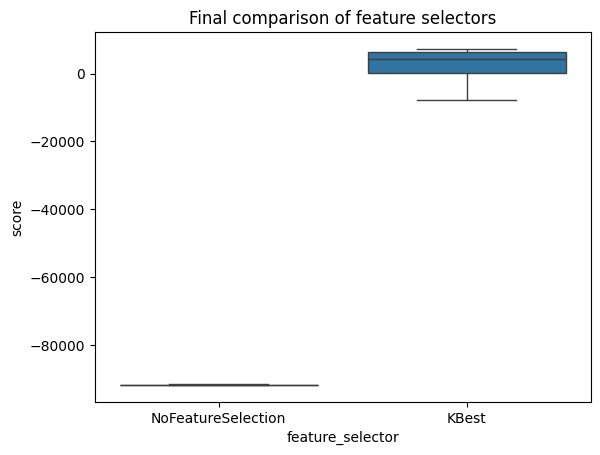

In [ ]:
plt.title("Final comparison of feature selectors")
sns.boxplot(data=processedResultsDf, x="feature_selector", y="score")
plt.show()

### Final Results for Models

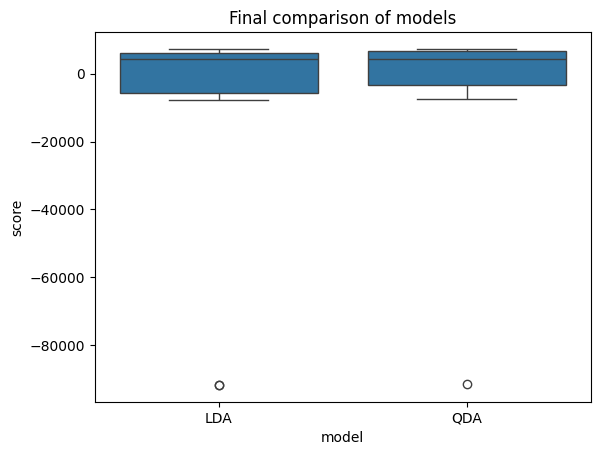

In [ ]:
plt.title("Final comparison of models")
sns.boxplot(data=processedResultsDf, x="model", y="score")
plt.show()

### Final Results

In [ ]:
%%time
filteredDf = filterDataframeByBestResults(processedResultsDf)

CPU times: total: 0 ns
Wall time: 3.5 ms


In [ ]:
filteredDf

,score,model,model_parameters,feature_selector,selector_parameters,selector_parameters_k,selector_parameters_score_func,model_parameters_solver
6,7330,LDA,{'solver': 'svd'},KBest,{'score_func': <function mutual_info_classif a...,5,mutual_info_classif,svd
17,7330,LDA,{'solver': 'lsqr'},KBest,{'score_func': <function mutual_info_classif a...,5,mutual_info_classif,lsqr
